<a href="https://colab.research.google.com/github/nurielw05/doc_transformers/blob/main/Copy_of_Copy_of_True_inference_with_LayoutLMv2ForTokenClassification_%2B_Gradio_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Inference with LayoutLMv2ForTokenClassification + Gradio demo

In this notebook, we are going to perform inference with `LayoutLMv2ForTokenClassification` on new document images, when no label information is accessible. At the end, we will also make a cool [Gradio](https://gradio.app/) demo, that turns our inference code into a cool web interface.

## Install libraries

Let's first install the required libraries:
* HuggingFace Transformers + Detectron2 (for the model)
* HuggingFace Datasets (for getting the data)
* PyTesseract (for OCR)

In [ ]:
!pip install -q transformers

In [ ]:
!pip install pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
#exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
!pip install -q datasets

In [ ]:
!sudo apt install tesseract-ocr
!pip install -q pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


## Load dataset

We load the FUNSD dataset from the hub, which I uploaded.

In [ ]:
from datasets import load_dataset 

datasets = load_dataset("nielsr/funsd")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset funsd downloaded and prepared to /root/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/8b0472b536a2dcb975d59a4fb9d6fea4e6a1abe260b7fed6f75301e168cbe595. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Let's create a list containing all unique labels, as well as dictionaries mapping integers to their label names and vice versa. This will be useful to convert the model's predictions to actual label names.

In [ ]:
labels = datasets['train'].features['ner_tags'].feature.names
print(labels)

['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


In [ ]:
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
label2id

{'O': 0,
 'B-HEADER': 1,
 'I-HEADER': 2,
 'B-QUESTION': 3,
 'I-QUESTION': 4,
 'B-ANSWER': 5,
 'I-ANSWER': 6}

## Inference

Let's test the trained model on the first image of the test set:

In [ ]:
example = datasets["test"][1]
print(example.keys())

dict_keys(['id', 'words', 'bboxes', 'ner_tags', 'image_path'])


We can visualize the document image using PIL:

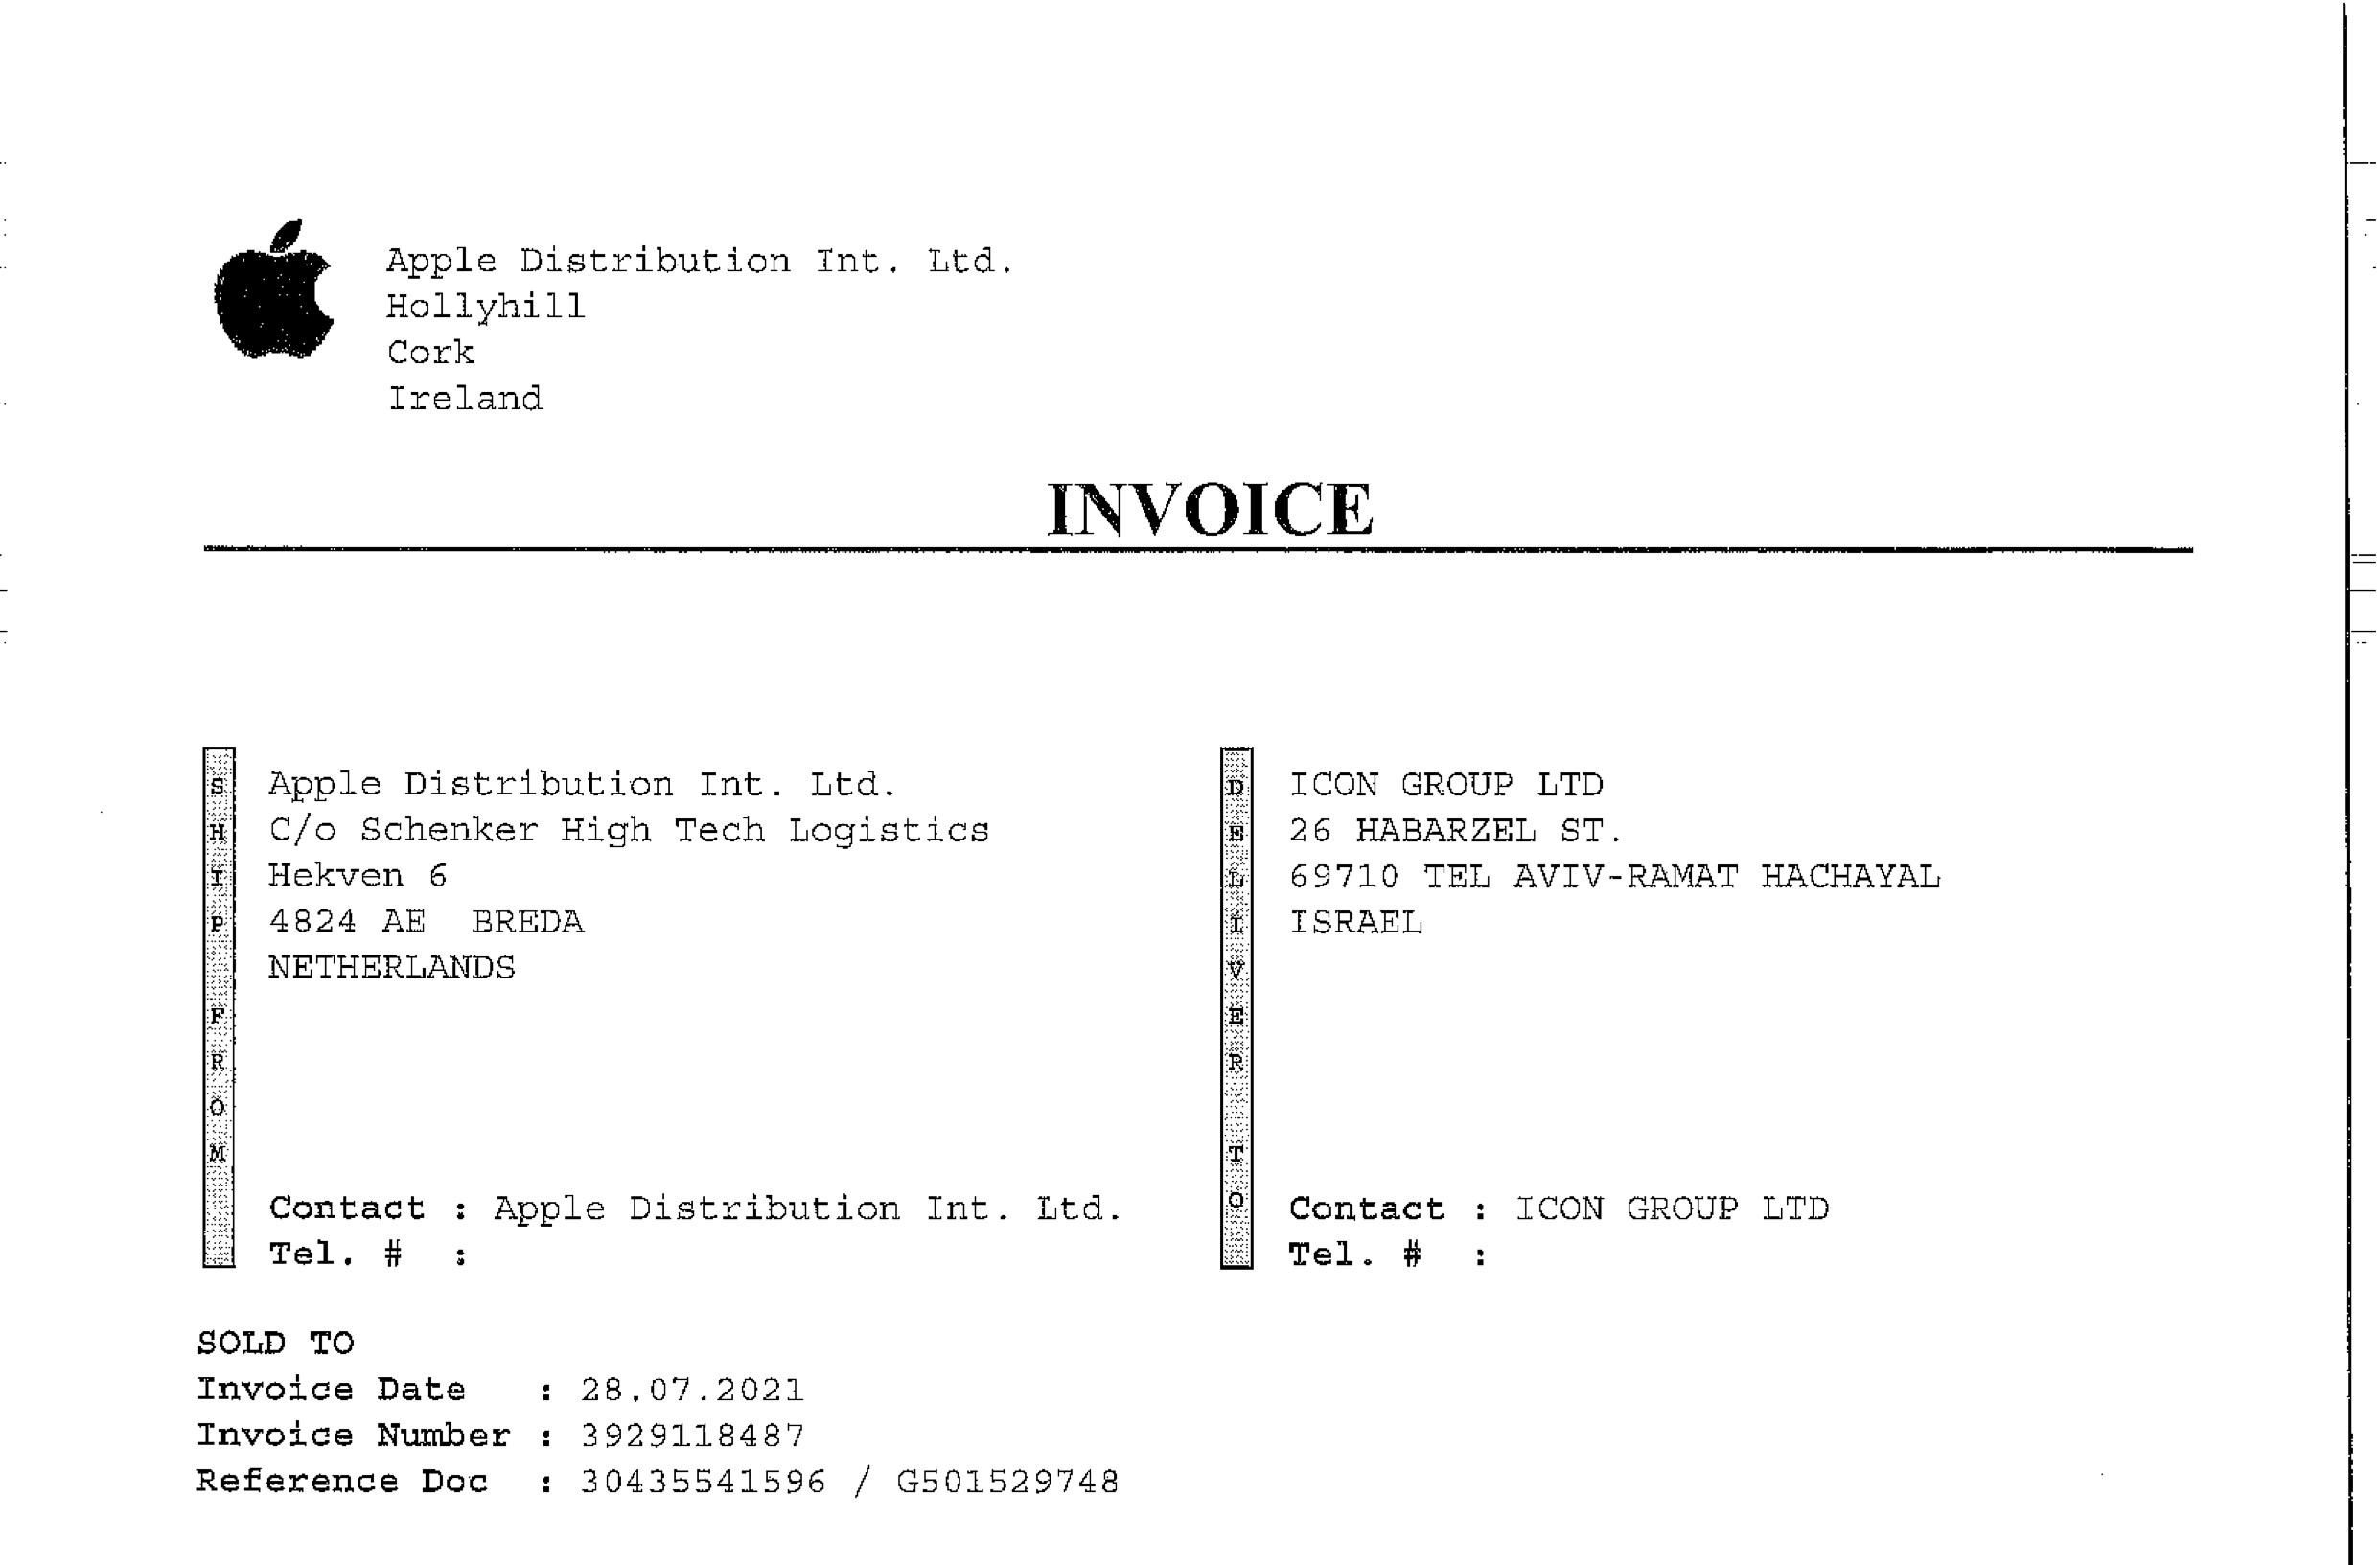

In [129]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/content/111222333.jpg")
image = image.convert("RGB")
image

We prepare it for the model using `LayoutLMv2Processor`.

In [130]:
from transformers import LayoutLMv2Processor

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")

encoding = processor(image, return_offsets_mapping=True, return_tensors="pt")
offset_mapping = encoding.pop('offset_mapping')
print(encoding.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])


Next, let's move everything to the GPU, if it's available.

In [131]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for k,v in encoding.items():
  encoding[k] = v.to(device)

In [132]:
from transformers import LayoutLMv2ForTokenClassification

# load the fine-tuned model from the hub
model = LayoutLMv2ForTokenClassification.from_pretrained("nielsr/layoutlmv2-finetuned-funsd")
model.to(device)

# forward pass
outputs = model(**encoding)
print(outputs.logits.shape)

torch.Size([1, 124, 7])


Let's create the true predictions as well as the true boxes. With "true", I mean only taking into account tokens that are at the start of a given word. We can use the `offset_mapping` returned by the processor to determine which tokens are a subword.

In [133]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

width, height = image.size

In [134]:
import numpy as np

is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

In [135]:
print(true_predictions)
print(true_boxes)

['I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-HEADER', 'B-ANSWER', 'B-ANSWER', 'B-ANSWER', 'B-HEADER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER']
[[0.0, 0.0, 0.0, 0.0], [402.24600000000004, 256.38100000000003, 516.4639999999999, 290.674], [543.777, 254.748, 824.356, 284.142], [851.669000000

Let's visualize the result!

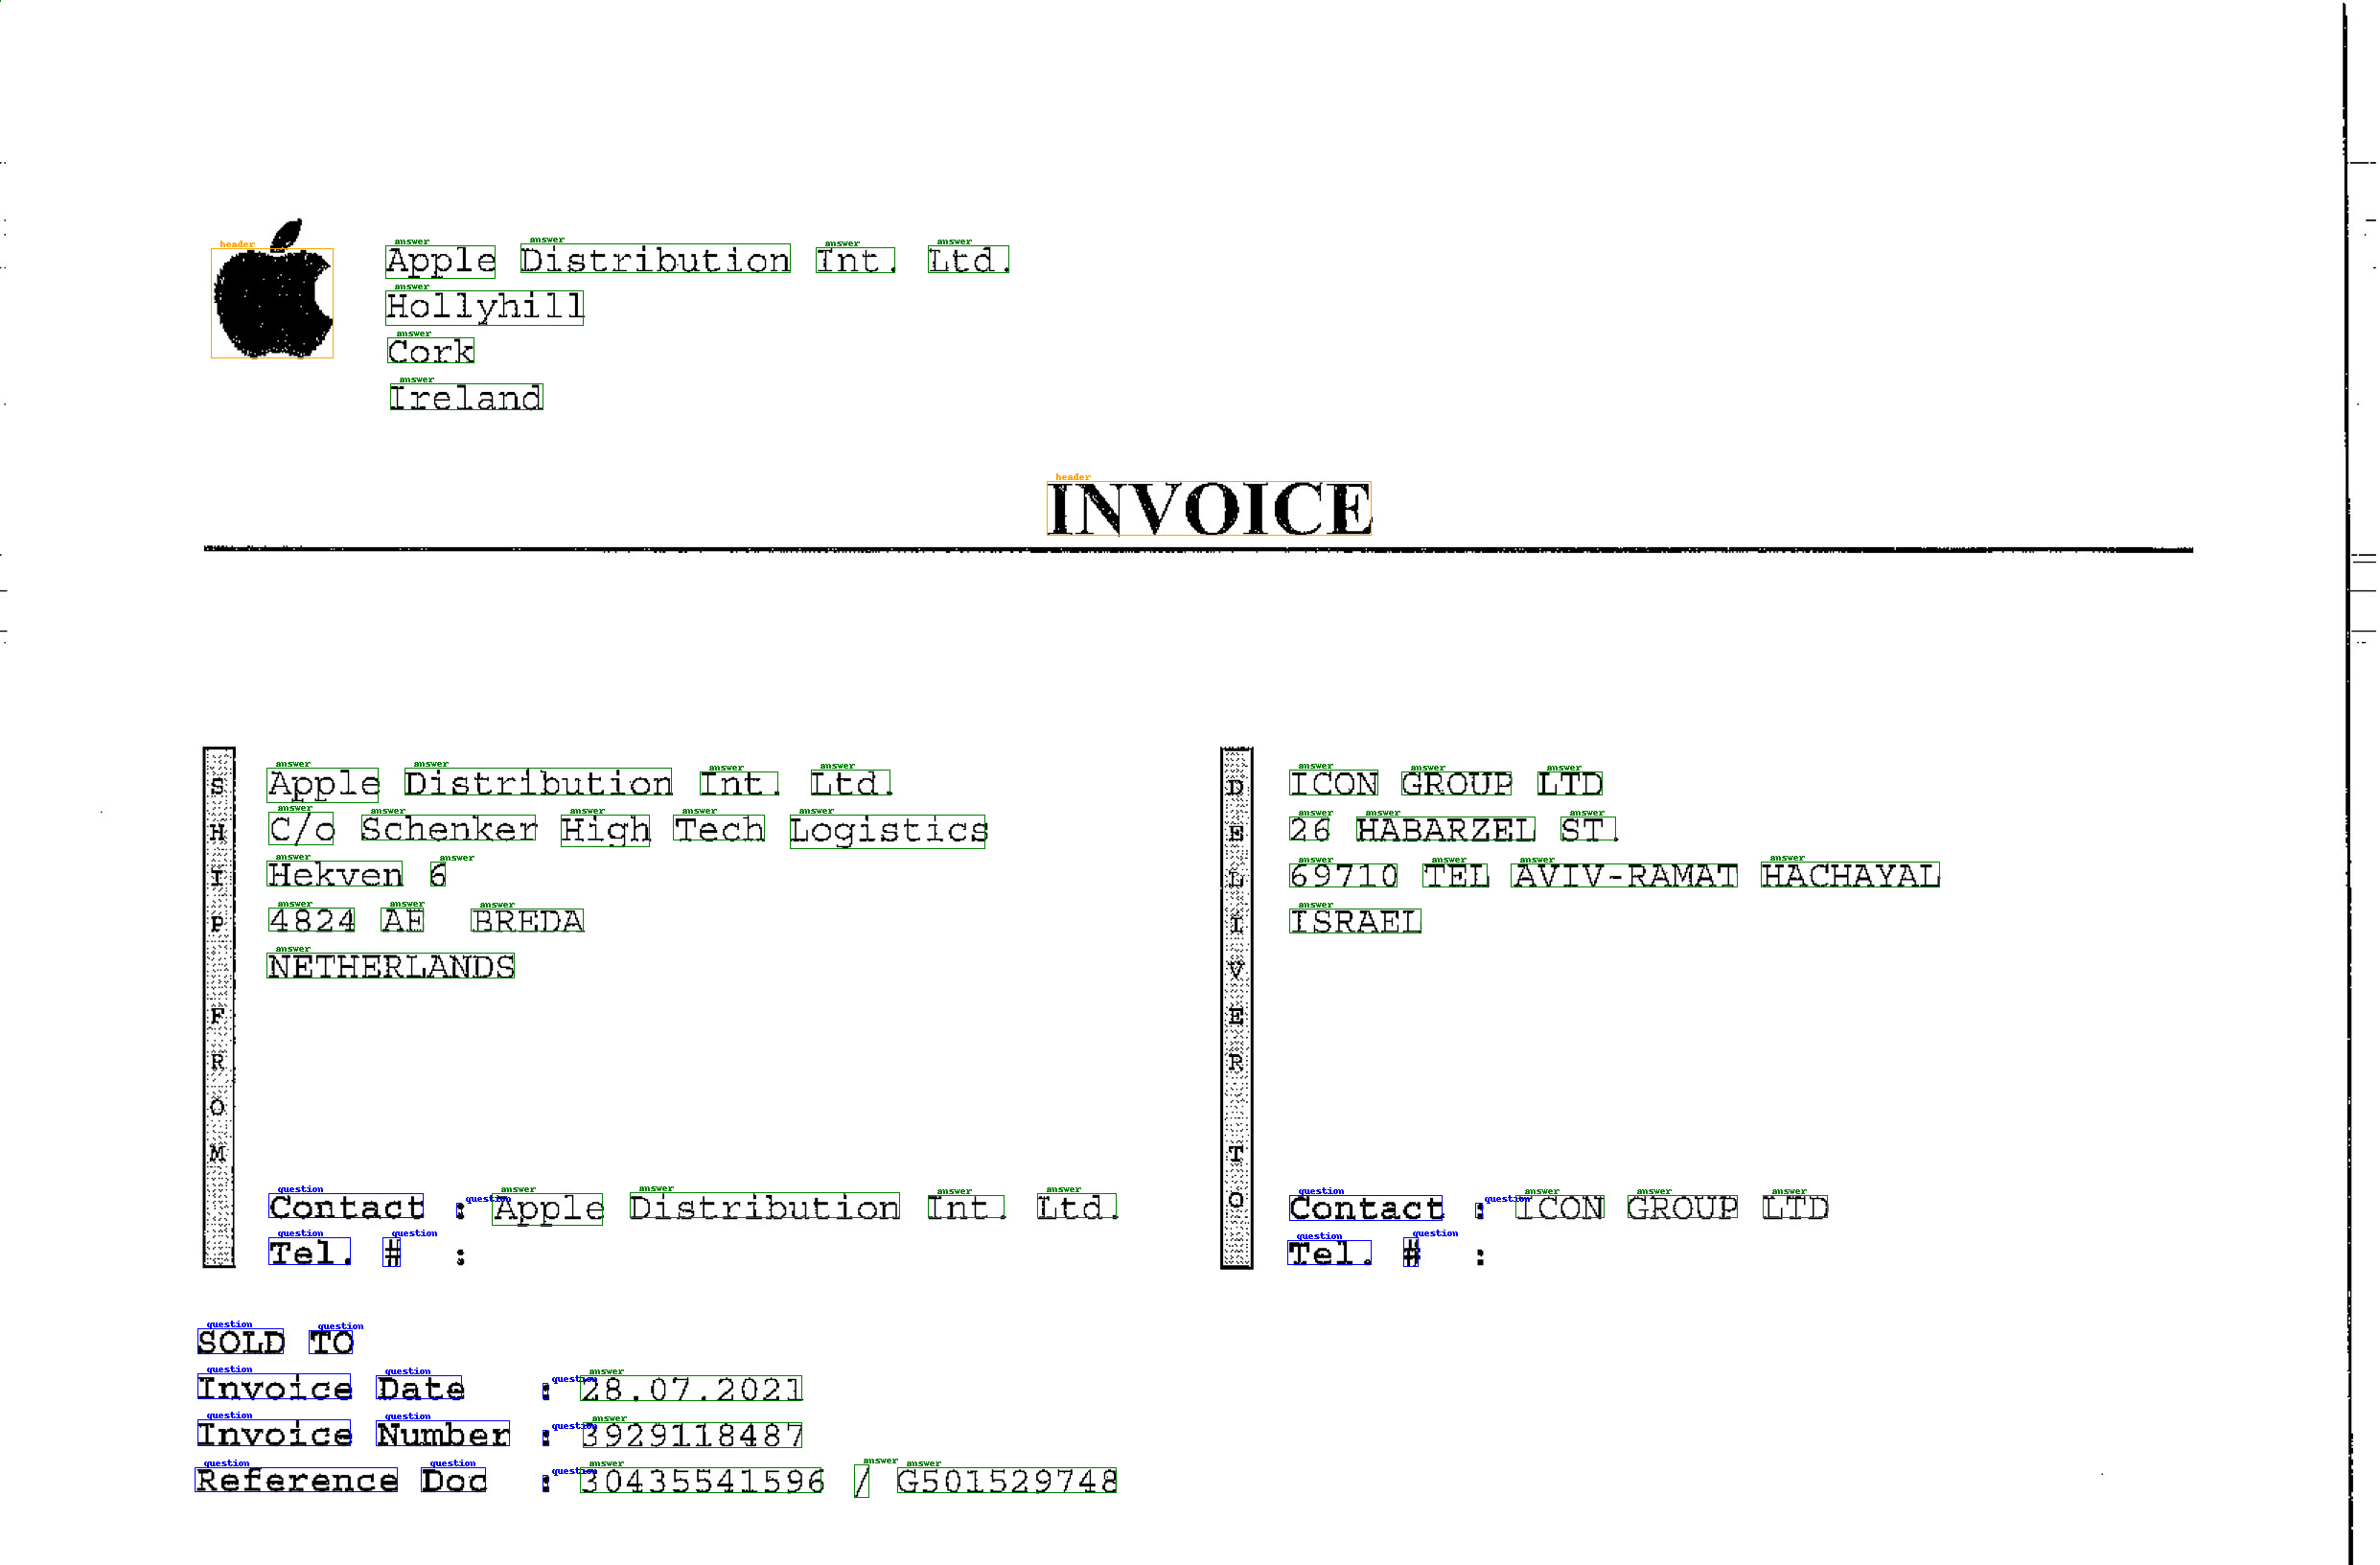

In [136]:
from PIL import ImageDraw

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

In [137]:
finalBoxes = []

for label, box in zip(true_predictions, true_boxes):
  finalBoxes.append([label, box])
  


print(finalBoxes)
print(len(finalBoxes))

[['I-ANSWER', [0.0, 0.0, 0.0, 0.0]], ['B-ANSWER', [402.24600000000004, 256.38100000000003, 516.4639999999999, 290.674]], ['I-ANSWER', [543.777, 254.748, 824.356, 284.142]], ['I-ANSWER', [851.6690000000001, 258.014, 933.608, 284.142]], ['I-ANSWER', [968.37, 256.38100000000003, 1052.792, 284.142]], ['B-HEADER', [220.987, 259.647, 347.62000000000006, 373.957]], ['B-ANSWER', [402.24600000000004, 303.738, 608.335, 339.664]], ['B-ANSWER', [404.72900000000004, 352.728, 494.117, 378.856]], ['B-ANSWER', [407.212, 400.085, 566.124, 427.846]], ['B-HEADER', [1092.52, 502.964, 1430.2079999999999, 558.486]], ['B-ANSWER', [278.096, 801.803, 394.797, 837.729]], ['I-ANSWER', [422.11, 801.803, 700.2059999999999, 829.564]], ['I-ANSWER', [730.002, 805.069, 811.941, 829.564]], ['I-ANSWER', [846.7030000000001, 803.436, 928.642, 829.564]], ['B-ANSWER', [280.579, 847.527, 347.62000000000006, 881.82]], ['I-ANSWER', [377.416, 850.793, 558.6750000000001, 876.921]], ['I-ANSWER', [585.9879999999999, 850.793, 677.8

In [138]:
image = Image.open("/content/111222333.jpg")
image = image.convert("RGB")
DrawBOXES = []
finalDraw = []
draw = ImageDraw.Draw(image)

for i in range(len(finalBoxes)):
  if i==0:
    i=i+1
  if(finalBoxes[i][0] == "B-QUESTION" or finalBoxes[i][0] == "B-ANSWER"):
    DrawBOXES.append([finalBoxes[i][1]])
  if(finalBoxes[i][0] == "I-QUESTION" or finalBoxes[i][0] == "I-ANSWER"):
    DrawBOXES[len(DrawBOXES)-1].append(finalBoxes[i][1])

def MaxValue(resultlist, index):
  boxesList = []
  for box in resultlist:
    boxesList.append(box[index])
  max_value = max(boxesList)
  return max_value

def MnValue(resultlist, index):
  boxesList = []
  for box in resultlist:
    boxesList.append(box[index])
  min_value = min(boxesList)
  return min_value


x = range(len(DrawBOXES))
for i in x:
  if(len(DrawBOXES[i])!=1):
    finalDraw.append([[MnValue(DrawBOXES[i], 0),MnValue(DrawBOXES[i], 1),MaxValue(DrawBOXES[i], 2),MaxValue(DrawBOXES[i], 3)]])
  else:
    finalDraw.append(DrawBOXES[i])

print(finalDraw)

[[[402.24600000000004, 256.38100000000003, 516.4639999999999, 290.674]], [[402.24600000000004, 254.748, 1052.792, 290.674]], [[402.24600000000004, 303.738, 608.335, 339.664]], [[404.72900000000004, 352.728, 494.117, 378.856]], [[407.212, 400.085, 566.124, 427.846]], [[278.096, 801.803, 928.642, 837.729]], [[280.579, 847.527, 1027.962, 885.086]], [[278.096, 898.1500000000001, 464.321, 924.2779999999999]], [[278.096, 947.14, 608.335, 1020.625]], [[1345.786, 803.436, 1671.0590000000002, 829.564]], [[1345.786, 852.426, 1685.957, 876.921]], [[1345.786, 899.7830000000001, 2023.6449999999998, 973.2679999999999]], [[280.579, 1245.979, 481.702, 1270.474]], [[513.981, 1244.346, 1164.527, 1278.6390000000001]], [[280.579, 1291.703, 417.144, 1321.097]], [[1345.786, 1247.612, 1546.909, 1273.74]], [[1581.671, 1247.612, 1906.944, 1270.474]], [[1343.303, 1291.703, 1479.868, 1321.097]], [[206.089, 1386.417, 367.484, 1412.545]], [[206.089, 1433.7740000000001, 571.09, 1459.902]], [[605.852, 1435.407, 836.

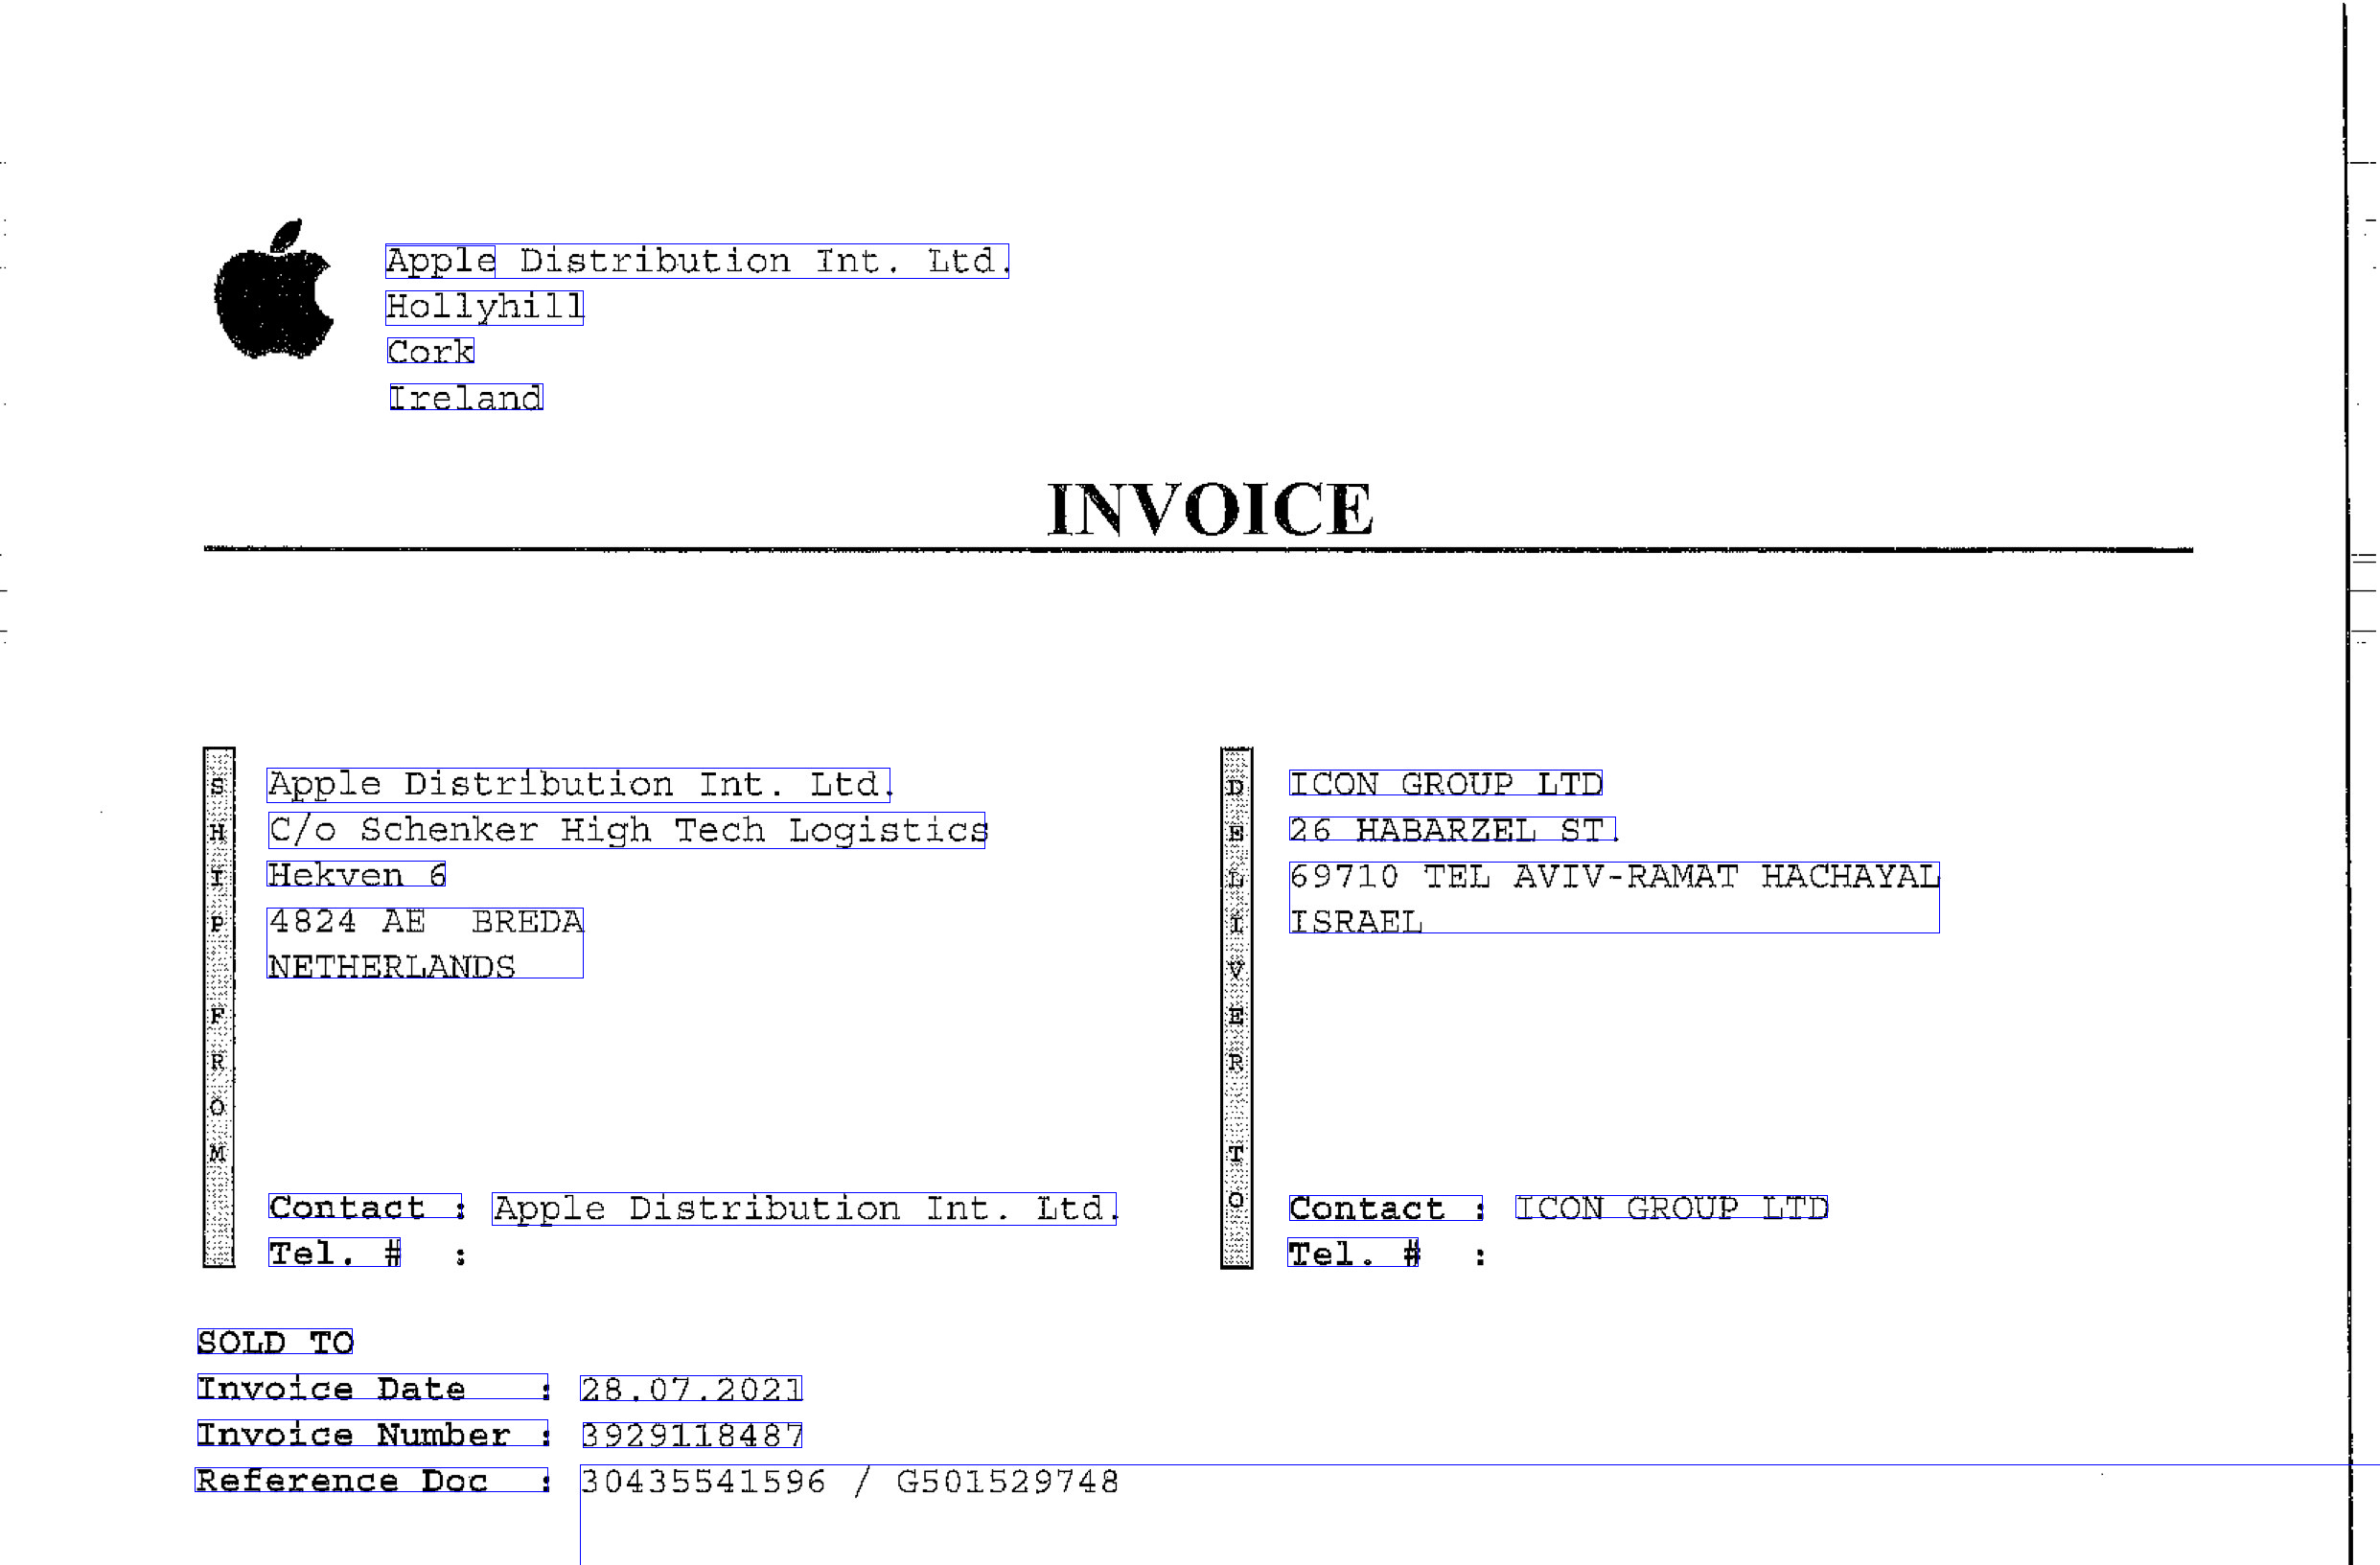

In [139]:
from PIL import ImageDraw
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

for box in finalDraw:
    draw.rectangle(box[0], fill=None, outline="blue", width=1)


image